# Imports and Plot Setup

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import AutoMinorLocator

from getdist import plots, MCSamples, loadMCSamples

import candl.plots

import getdist

In [2]:
# Custom matplotlib legend entry for two lines
from matplotlib.legend_handler import HandlerBase
from matplotlib.lines import Line2D

class HandlerTwoLines(HandlerBase):
    def __init__(self, colors=['k', 'k'], linestyles=['-', '--'], linewidths=[1., 1.]):
        self.colors = colors
        self.linestyles = linestyles
        self.linewidths = linewidths
        super().__init__()

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # Create two horizontal lines, one above the other with more separation
        lines = []
        
        # Top line (solid)
        y_top = ydescent + height * 0.65
        line1 = Line2D([xdescent, xdescent + width], [y_top, y_top],
                       color=self.colors[0], linestyle=self.linestyles[0], 
                       linewidth=self.linewidths[0], transform=trans)
        
        # Bottom line (dashed) - more separated
        y_bottom = ydescent + height * 0.2
        line2 = Line2D([xdescent, xdescent + width], [y_bottom, y_bottom],
                       color=self.colors[1], linestyle=self.linestyles[1],
                       linewidth=self.linewidths[1], transform=trans)
        
        lines.extend([line1, line2])
        return lines

# Set the plot style
import candl.plots
candl.plots.set_plot_style()
from cycler import cycler
import seaborn as sns

def set_plot_style(params=None, columnwidth=246, height_ratio=1.618):
    plt.rcParams.update(
        {
            # Use LaTeX to write all text
            "text.usetex": True,
            # "text.latex.unicode": True,
            "font.family": "serif",
            "font.serif": ["Computer Modern Roman"],
            "figure.figsize": (columnwidth / 72, columnwidth / 72 / height_ratio),
            # To have access to AMS maths commands
            "text.latex.preamble": r'\usepackage{amsmath, xfrac}', # \usepackage{amsfonts} \DeclareMathSymbol{\shortminus}{\mathbin}{AMSa}{"39}', # \DeclareUnicodeCharacter{2212}{$\text{-}$}",
            # "axes.unicode_minus": False,
            # Use 10pt font in plots, to match 10pt font in document
            "axes.labelsize": 10,
            "font.size": 10,
            # false grid
            "axes.grid": False,
            # Make the legend/label fonts a little smaller
            "legend.fontsize": 10,
            "legend.frameon": False,
            "axes.titlesize": 10,
            "axes.linewidth": 1.5,
            "xtick.labelsize": 8,
            "ytick.labelsize": 8,
            # tick inside
            "xtick.direction": "in",
            "ytick.direction": "in",
            "xtick.major.size": 3,
            "ytick.major.size": 3,
            "xtick.minor.size": 1.5,
            "ytick.minor.size": 1.5,
            "xtick.major.width": 1.,
            "ytick.major.width": 1.,
            "xtick.minor.width": 1.,
            "ytick.minor.width": 1.,
            "axes.xmargin": 0.02,
            # "axes.ymargin": 0.02,
            # change the color cycle
            "axes.prop_cycle": cycler(
                linestyle=["-", "--", "-.", ":", (0, (3, 5, 1, 5))]*2,
                color=sns.color_palette('colorblind')
            ),
            # savefig
            "savefig.dpi": 300,
            "savefig.format": "pdf",
            "savefig.bbox": "tight",
            "savefig.facecolor": '#FF000000',
        }
    )
    if params is not None:
        plt.rcParams.update(params)
    return plt.rcParams

set_plot_style()

def create_dummy_plot_elements_for_legend(all_dat, return_entries=False):
     # need to create dummy plot elements that the legend will pick up
     # first check if the custom two line entry needs to be used, then cycle through regular legend labels
     legend_handles = []
     legend_labels = []
     handler_map = {}
     for dat in all_dat:
          if "FC" in all_dat and "FC_DESI" in all_dat:
               if dat == "FC":
                    # Add the custom two-line entry
                    dummy_handle_combined = plt.Line2D([], [], color='k')
                    legend_handles.append(dummy_handle_combined)
                    legend_labels.append("CMB 2030s")
                    handler_map[dummy_handle_combined] = HandlerTwoLines()
                    continue
               else:
                    continue
          if style_dict[dat]["filled"]:
               handle = ax.fill_between([2, 2],
                         [2, 2],
                         [2, 2],
                         color=style_dict[dat]["colour"],
                         lw=0,
                         label=style_dict[dat]["label"])
          else:
               handle = ax.plot([2, 2],
                         [2, 2],
                         color=style_dict[dat]["colour"],
                         ls=style_dict[dat]["ls"],
                         label=style_dict[dat]["label"])
          legend_handles.append(handle)
          legend_labels.append(style_dict[dat]["label"])
     if return_entries:
          return legend_handles, legend_labels, handler_map

# Load Data

In [3]:
chain_files = {
    "SPA_BK": "chains/SPA_BK/CLASS",
    "SPA_BK_DESI": "chains/SPA_BK_DESI/CLASS",
}

# Load in chains
chains = {}
bf_dicts = {}
for key, value in chain_files.items():
    chains[key] = loadMCSamples(value, settings={"ignore_rows": 0.2})
    bf_dicts[key] = chains[key].getParamBestFitDict()


In [4]:
# Simple forecast (preserve r-ns correlation of real data)
def cov_2_corr(H):
    S = np.diag(1/np.sqrt(np.abs(np.diag(H))))
    return S @ H @ S

par_order = ["r", "n_s"]
par_cov = chains["SPA_BK"].cov(par_order)
par_diag = np.sqrt(np.diag(par_cov))
par_diag[par_order.index("r")] = 1e-3
par_diag[par_order.index("n_s")] = 2e-3
par_cov_scaled = np.outer(par_diag, par_diag)*cov_2_corr(par_cov)
mrg = chains["SPA_BK"].getMargeStats()
fid_dict = {"r": 3e-3, "n_s": mrg.parWithName("n_s").mean}

mrg_desi = chains["SPA_BK_DESI"].getMargeStats()
fid_dict_desi = {"r": 3e-3, "n_s": mrg_desi.parWithName("n_s").mean}

chains["FC"] = getdist.gaussian_mixtures.GaussianND(np.array([fid_dict[p] for p in par_order]),
                                                    par_cov_scaled,
                                                    names=par_order)

chains["FC_DESI"] = getdist.gaussian_mixtures.GaussianND(np.array([fid_dict_desi[p] for p in par_order]),
                                                    par_cov_scaled,
                                                    names=par_order)

In [5]:
# Define plot style for all data sets
style_dict = {
            "SPA_BK":
                 {"colour": sns.color_palette('colorblind')[0],
                 "ls": "-",
                 "lw": 0.75,
                 "filled": True,
                 "label": "SPA+BK"},
            "SPA_BK_DESI":
                 {"colour": sns.color_palette('colorblind')[-1],
                 "ls": "-",
                 "lw": 1.5,
                 "filled": False,
                 "label": "SPA+BK+DESI"},
            "FC":
                 {"colour": "k",
                 "ls": "-",
                 "lw": 1.5,
                 "filled": False,
                 "label": "CMB 2030s"},
            "FC_DESI":
                 {"colour": "k",
                 "ls": "--",
                 "lw": 1.5,
                 "filled": False,
                 "label": "CMB 2030s+DESI"},
}

alpha_unity_style_dict = {"Starobinsky $R^2$": {"color": "k", "s": 50, "marker": "s"},
                          "Higgs": {"color": "w", "edgecolor": "k", "s": 70, "marker": "o"}}

In [6]:
# Helper functions for theory plot elements

# From BK script
def N_r_ns(r, ns):
    return (r - 16) / (8. * ns - 8 + r) / 2.

def r_ns(ns, p):
    return 8. * (1 - ns) * p / (2. + p)

def ns_N(N, p):  # first order
    return (4 * N - p - 4) / (4. * N + p)

# For e fold range of polynomial potentials
def r_from_N_star_ns(Nstar, n_s):
    denom = 1-2*Nstar
    num = 2*Nstar*(8*n_s-8)+16
    return num/denom

# Simple, Clean Plot

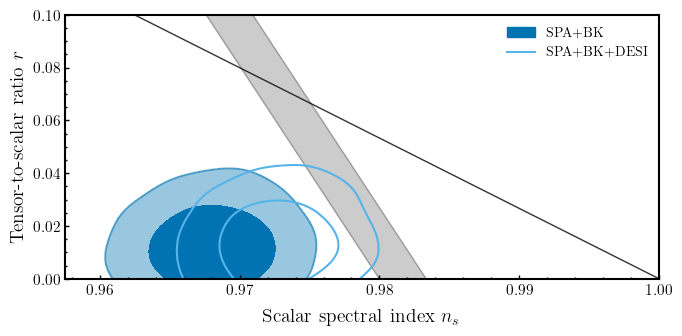

In [10]:
plt.close()

g = plots.get_single_plotter(width_inch=2.0*3.464, ratio=0.5)
g.settings.legend_frame = False

ax = plt.gca()

# Data constraints
all_dat = ["SPA_BK", "SPA_BK_DESI"]
g.plot_2d([chains[dat] for dat in all_dat],
          ["ns", "r"],
          colors=[style_dict[dat]["colour"] for dat in all_dat],
          ls=[style_dict[dat]["ls"] for dat in all_dat],
          lws=[style_dict[dat]["lw"] for dat in all_dat],
          filled=[style_dict[dat]["filled"] for dat in all_dat])

# Range of 50-60 e-folds for polynomial potentials
ns = np.linspace(0.96, 1.0, 100)
ax.fill_between(ns,
                r_from_N_star_ns(50, ns),
                r_from_N_star_ns(60, ns),
                lw=1,
                facecolor="0.8",
                edgecolor="0.6",
                zorder=-1)

# Concave/Convex divide
ax.plot(ns, r_ns(ns, 1), ls='-', color='k', lw=1, alpha=0.8)

# Legend
g.add_legend(["SPA+BK", "SPA+BK+DESI"],
             fontsize=10)

# Set the axis limits
ax.set_ylim((0, 0.1))
ax.set_xlim((0.9575, 1.0))

# Create minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# Label axes
ax.set_ylabel("Tensor-to-scalar ratio $r$")
ax.set_xlabel("Scalar spectral index $n_s$")

# Finish the plot
plt.tight_layout()

plt.show()

# Paper Plots

## Data Plot

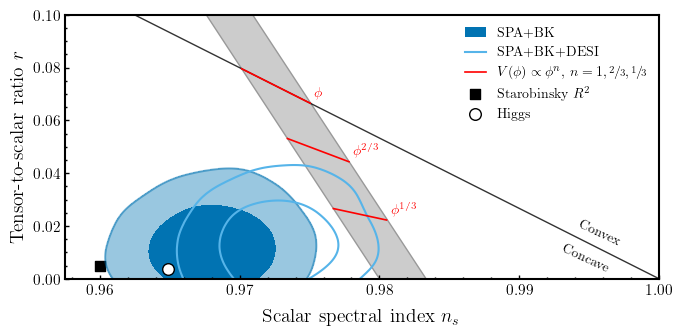

In [8]:
plt.close()

g = plots.get_single_plotter(width_inch=2.0*3.464, ratio=0.5)
ax = plt.gca()

# Data constraints
all_dat = ["SPA_BK", "SPA_BK_DESI"]
g.plot_2d([chains[dat] for dat in all_dat],
          ["ns", "r"],
          colors=[style_dict[dat]["colour"] for dat in all_dat],
          ls=[style_dict[dat]["ls"] for dat in all_dat],
          lws=[style_dict[dat]["lw"] for dat in all_dat],
          filled=[style_dict[dat]["filled"] for dat in all_dat])
create_dummy_plot_elements_for_legend(all_dat)

# Power law potentials
ns = np.arange(0.9, 1.1, 0.0001)
ax.plot(ns, r_ns(ns, 1), ls='-', color='k', lw=1, alpha=0.8)

for p, p_label in zip([1/3, 2/3, 1], ["1/3", "2/3", ""]):
    lbl = None
    if p ==1:
        lbl = r"$V(\phi) \propto \phi^{n},\, n=1, \sfrac{2}{3}, \sfrac{1}{3}$"
    ns = np.arange(ns_N(50, p), ns_N(60, p), 0.0001)
    ax.plot(ns, r_ns(ns, p), ls='-', color="r", lw=1.2, alpha=1, label=lbl)
    ax.text(0.00025+ns_N(60, p), 0.0025+r_ns(ns_N(60, p), p), f"$\phi^{{{p_label}}}$", color="r", ha="left")# Carefully place the text for polynomial potentials

# Range of 50-60 e-folds for polynomial potentials
ns = np.linspace(0.96, 1.0, 100)
ax.fill_between(ns,
                r_from_N_star_ns(50, ns),
                r_from_N_star_ns(60, ns),
                lw=1,
                facecolor="0.8",
                edgecolor="0.6",
                zorder=-1)

# Starobinsky, Higgs markers
N_efolds_alpha_unity = {"Starobinsky $R^2$": 50,
                              "Higgs": 57}

for model in list(N_efolds_alpha_unity.keys()):
    this_r = 12/N_efolds_alpha_unity[model]**2
    this_ns = 1-2/N_efolds_alpha_unity[model]
    ax.scatter(this_ns, this_r, **alpha_unity_style_dict[model], label=model)

# Concave/Convex text
ax.text(0.875, 0.075, 
        "Concave",
        transform=ax.transAxes,
        ha="center",
        va="center",
        rotation=-25,
        fontsize=10)
ax.text(0.9, 0.175,
        "Convex",
        transform=ax.transAxes,
        ha="center",
        va="center",
        rotation=-25,
        fontsize=10)

# Legend
ax.legend(loc="upper right",
          ncol=1,
          fontsize=10,
          handlelength=1.5)

# Set the axis limits
ax.set_ylim((0, 0.1))
ax.set_xlim((0.9575, 1.0))

# Create minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# Label axes
ax.set_ylabel("Tensor-to-scalar ratio $r$")
ax.set_xlabel("Scalar spectral index $n_s$")

# Finish the plot
plt.tight_layout()

plt.show()

## Forecast Plot

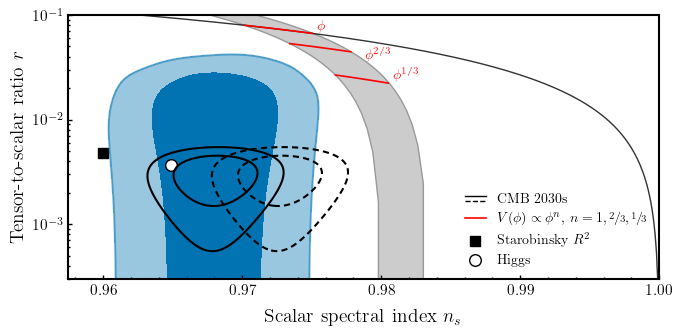

In [9]:
plt.close()

g = plots.get_single_plotter(width_inch=2.0*3.464, ratio=0.5)
ax = plt.gca()

# Data constraints
all_dat = ["SPA_BK", "FC", "FC_DESI"]
g.plot_2d([chains[dat] for dat in all_dat],
          ["ns", "r"],
          colors=[style_dict[dat]["colour"] for dat in all_dat],
          ls=[style_dict[dat]["ls"] for dat in all_dat],
          lws=[style_dict[dat]["lw"] for dat in all_dat],
          filled=[style_dict[dat]["filled"] for dat in all_dat])
legend_handles, legend_labels, handler_map = create_dummy_plot_elements_for_legend(all_dat, True)

# Power law potentials
ns = np.arange(0.9, 1.1, 0.0001)
ax.plot(ns, r_ns(ns, 1), ls='-', color='k', lw=1, alpha=0.8)

phi_text_placement = {"1/3": [0.00025, 0.0025],
                      "2/3": [4*0.00025, -2.5*0.0025],
                      "": [0.00025, 2*0.0025]}

for p, p_label in zip([1/3, 2/3, 1], ["1/3", "2/3", ""]):
    lbl = None
    if p ==1:
        lbl = r"$V(\phi) \propto \phi^{n},\, n=1, \sfrac{2}{3}, \sfrac{1}{3}$"
    ns = np.arange(ns_N(50, p), ns_N(60, p), 0.0001)
    line_handle = ax.plot(ns, r_ns(ns, p), ls='-', color="r", lw=1.2, alpha=1, label=lbl)
    if p == 1:
        polynomial_handle = line_handle[0]
        legend_handles.append(polynomial_handle)
        legend_labels.append(lbl)
    ax.text(ns_N(60, p)+phi_text_placement[p_label][0], r_ns(ns_N(60, p), p)+phi_text_placement[p_label][1], f"$\phi^{{{p_label}}}$", color="r", ha="left")

# Range of 50-60 e-folds for polynomial potentials
ns = np.linspace(0.96, 1.0, 100)
ax.fill_between(ns,
                r_from_N_star_ns(50, ns),
                r_from_N_star_ns(60, ns),
                lw=1,
                facecolor="0.8",
                edgecolor="0.6",
                zorder=-1)

# Starobinsky, Higgs markers
N_efolds_alpha_unity = {"Starobinsky $R^2$": 50,
                              "Higgs": 57}

for model in list(N_efolds_alpha_unity.keys()):
    this_r = 12/N_efolds_alpha_unity[model]**2
    this_ns = 1-2/N_efolds_alpha_unity[model]
    handle = ax.scatter(this_ns, this_r, **alpha_unity_style_dict[model], label=model)
    legend_handles.append(handle)
    legend_labels.append(model)

# Legend
ax.legend(handles=legend_handles, 
          labels=legend_labels,
          handler_map=handler_map,
          loc="lower right",
          ncol=1,
          fontsize=10,
          handlelength=1.5)

# Set the axis limits, log axis
ax.set_ylim((3e-4, 1e-1))
ax.set_xlim((0.9575, 1.0))
ax.set_yscale("log")

# Create minor ticks
ax.xaxis.set_minor_locator(AutoMinorLocator())

# Label axes
ax.set_ylabel("Tensor-to-scalar ratio $r$")
ax.set_xlabel("Scalar spectral index $n_s$")

# Finish the plot
plt.tight_layout()

plt.show()